In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import psycopg2
from sqlalchemy import create_engine
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [5]:
conn = psycopg2.connect(
    host='localhost', port=5432, database='city_marketing',
    user='postgres', password='1234'
)
vehicle_df = pd.read_sql("SELECT * FROM vehicle_counters", conn)
conn.close()

In [6]:

print(f"Dataset Size: {len(vehicle_df):,} records")
print(f"Measurement Sites: {vehicle_df['site_id'].nunique()}")
print(f"Transport Modes: {vehicle_df['mode'].nunique()}")
print(f"Total Vehicles Counted: {vehicle_df['count'].sum():,}")
print(f"Time Period: {vehicle_df['timestamp'].min()} to {vehicle_df['timestamp'].max()}")

Dataset Size: 10,000 records
Measurement Sites: 97
Transport Modes: 8
Total Vehicles Counted: 553,448
Time Period: 2020-08-05 23:00:00+00:00 to 2025-04-10 21:00:00+00:00


In [7]:
print("DATA STRUCTURE")
print(f"Shape: {vehicle_df.shape}")
print(f"Columns: {list(vehicle_df.columns)}")
print("\nFirst 5 records:")
vehicle_df.head()

DATA STRUCTURE
Shape: (10000, 10)
Columns: ['trajectory_id', 'site_id', 'site_label', 'mode', 'count', 'direction', 'lane', 'timestamp', 'longitude', 'latitude']

First 5 records:


,trajectory_id,site_id,site_label,mode,count,direction,lane,timestamp,longitude,latitude
0,10004_5 -> 3,10004,CF0256_88 rue de Rivoli,Autobus et autocars,4,E-O,Voie de circulation générale,2025-04-09 22:00:00+00:00,2.349109,48.858273
1,10004_1 -> 1,10004,CF0256_88 rue de Rivoli,Trottinettes,4,O-E,Piste cyclable,2025-04-10 00:00:00+00:00,2.349109,48.858273
2,10004_4 -> 2,10004,CF0256_88 rue de Rivoli,Trottinettes,5,E-O,Coronapiste,2025-04-10 01:00:00+00:00,2.349109,48.858273
3,10004_5 -> 3,10004,CF0256_88 rue de Rivoli,"Véhicules lourds > 3,5t",8,E-O,Voie de circulation générale,2025-04-10 02:00:00+00:00,2.349109,48.858273
4,10004_4 -> 2,10004,CF0256_88 rue de Rivoli,Vélos,51,E-O,Coronapiste,2025-04-10 04:00:00+00:00,2.349109,48.858273


In [8]:
df = vehicle_df.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.day_name()
df['date'] = df['timestamp'].dt.date

mode_mapping = {
    'Vélos': 'Bikes', 'Trottinettes': 'Scooters', 
    'Autobus et autocars': 'Buses', 'Véhicules lourds > 3,5t': 'Heavy Vehicles',
    '2 roues motorisées': 'Motorcycles', 'Trottinettes + vélos': 'Mixed'
}
df['mode_clean'] = df['mode'].map(mode_mapping).fillna(df['mode'])

TRAFFIC VOLUME METRICS
Total Traffic: 553,448
Average per Record: 55.3
Daily Average: 4612
Peak Single Count: 1428


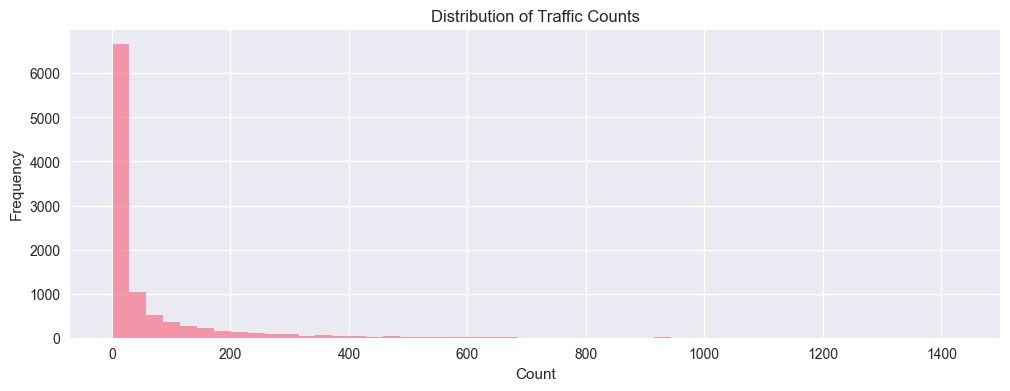

In [9]:
print("TRAFFIC VOLUME METRICS")
print(f"Total Traffic: {df['count'].sum():,}")
print(f"Average per Record: {df['count'].mean():.1f}")
print(f"Daily Average: {df.groupby('date')['count'].sum().mean():.0f}")
print(f"Peak Single Count: {df['count'].max()}")

plt.figure(figsize=(12, 4))
df['count'].hist(bins=50, alpha=0.7)
plt.title('Distribution of Traffic Counts')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

TRANSPORT MODE PERFORMANCE
                          Total  Average  Records  Share%
mode_clean                                               
Véhicules légers < 3,5t  199630    123.0     1623    36.1
Mixed                    152654     81.2     1880    27.6
Bikes                     98442     96.5     1020    17.8
Motorcycles               55502     31.9     1741    10.0
Scooters                  17291     12.5     1383     3.1
van                       10385     25.0      416     1.9
Buses                     10239     11.0      935     1.9
Heavy Vehicles             9305      9.3     1002     1.7


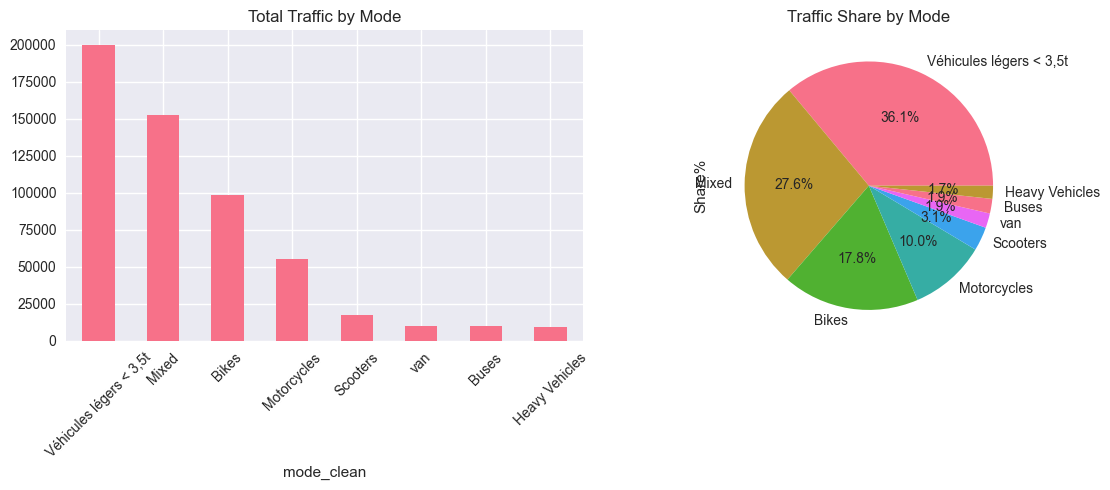

In [10]:
mode_stats = df.groupby('mode_clean')['count'].agg(['sum', 'mean', 'count']).round(1)
mode_stats.columns = ['Total', 'Average', 'Records']
mode_stats = mode_stats.sort_values('Total', ascending=False)
mode_stats['Share%'] = (mode_stats['Total'] / mode_stats['Total'].sum() * 100).round(1)

print("TRANSPORT MODE PERFORMANCE")
print(mode_stats)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
mode_stats['Total'].plot(kind='bar')
plt.title('Total Traffic by Mode')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
mode_stats['Share%'].plot(kind='pie', autopct='%1.1f%%')
plt.title('Traffic Share by Mode')
plt.tight_layout()
plt.show()

PEAK TRAFFIC TIMES
Peak Hour: 16:00 (42,287 vehicles)
Peak Day: Thursday (173,704 vehicles)


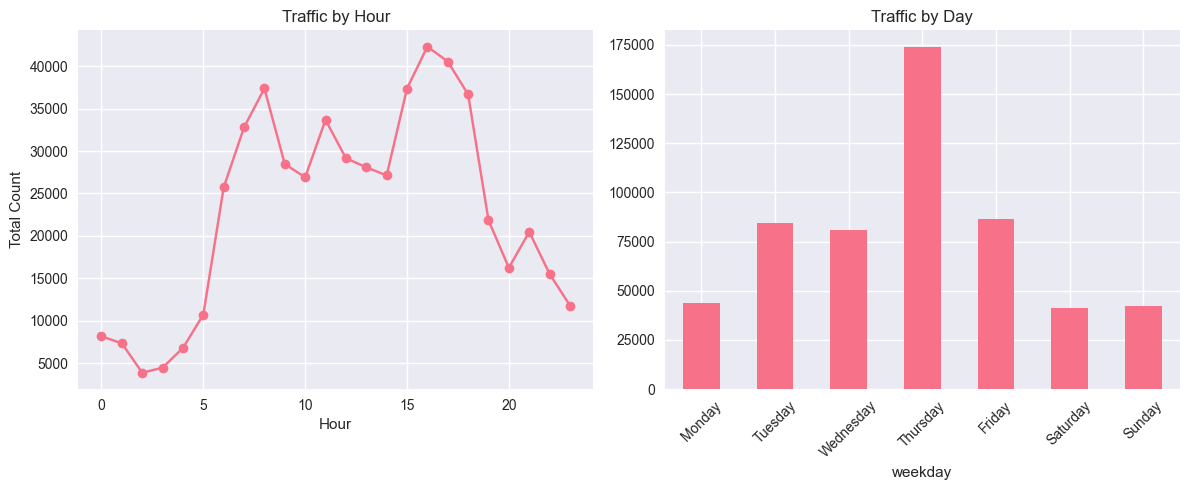

In [11]:
hourly_traffic = df.groupby('hour')['count'].sum()
daily_traffic = df.groupby('weekday')['count'].sum()

print("PEAK TRAFFIC TIMES")
print(f"Peak Hour: {hourly_traffic.idxmax()}:00 ({hourly_traffic.max():,} vehicles)")
print(f"Peak Day: {daily_traffic.idxmax()} ({daily_traffic.max():,} vehicles)")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
hourly_traffic.plot(marker='o')
plt.title('Traffic by Hour')
plt.xlabel('Hour')
plt.ylabel('Total Count')

plt.subplot(1, 2, 2)
daily_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_traffic.reindex(daily_order).plot(kind='bar')
plt.title('Traffic by Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

TOP 10 BUSIEST LOCATIONS
                                              Total  Average  Records
site_label                                                           
                                             128814     54.2     2375
CF0004_2 boulevard Montmartre (sens E-O)      71913     74.5      965
CF0256_88 rue de Rivoli                       69664     42.0     1657
CF0892_65 rue de Rivoli (Bourdonnais)         66293     66.8      992
CF0318_29 rue de Rivoli (Lobau)               50046     48.7     1027
CF0181_101 rue d'Amsterdam                    36921     61.5      600
CF0004_29 boulevard Poissonnière (sens O-E)   21823     46.6      468
143 quai de Valmy                             19981     52.0      384
134 quai de Jemmapes                          11932     48.5      246
CF0001_9 boulevard de Sébastopol               5636     76.2       74


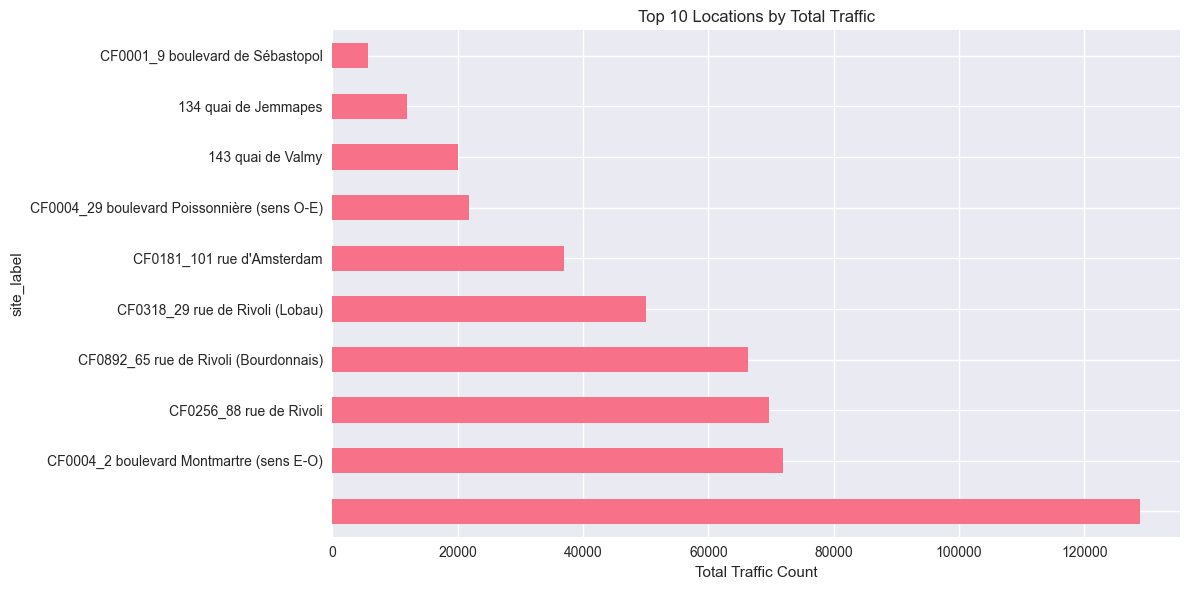

In [12]:
location_stats = df.groupby('site_label')['count'].agg(['sum', 'mean', 'count']).round(1)
location_stats.columns = ['Total', 'Average', 'Records']
location_stats = location_stats.sort_values('Total', ascending=False)

print("TOP 10 BUSIEST LOCATIONS")
print(location_stats.head(10))

top_10 = location_stats.head(10)['Total']
plt.figure(figsize=(12, 6))
top_10.plot(kind='barh')
plt.title('Top 10 Locations by Total Traffic')
plt.xlabel('Total Traffic Count')
plt.tight_layout()
plt.show()

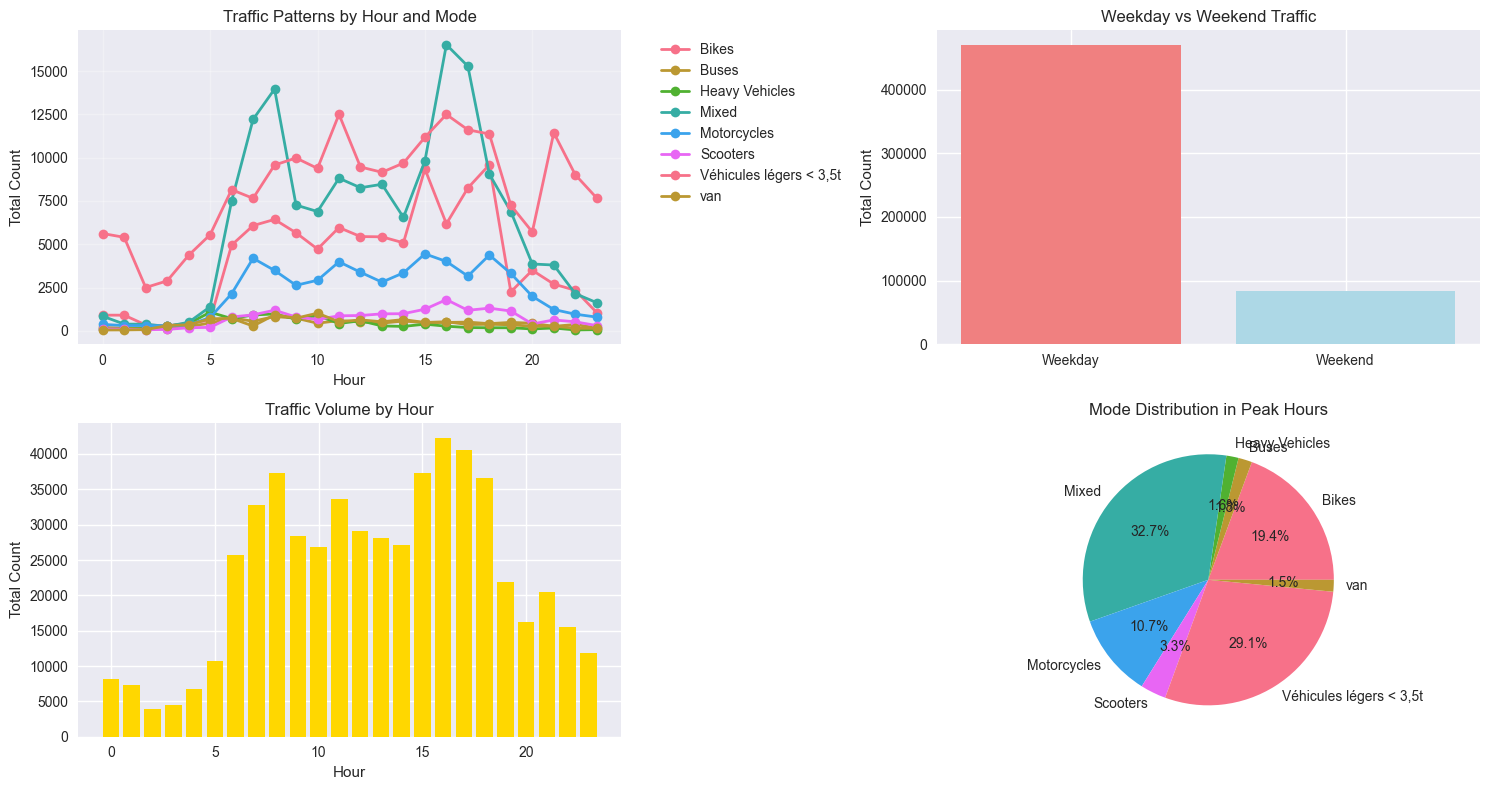

Weekday Traffic: 469,571
Weekend Traffic: 83,877
Weekend represents 17.9% of weekday volume


In [13]:
# Peak hours and mode patterns
hourly_by_mode = df.groupby(['hour', 'mode_clean'])['count'].sum().unstack(fill_value=0)

plt.figure(figsize=(15, 8))

# Traffic patterns by hour and mode
plt.subplot(2, 2, 1)
for mode in hourly_by_mode.columns:
    plt.plot(hourly_by_mode.index, hourly_by_mode[mode], marker='o', label=mode, linewidth=2)
plt.title('Traffic Patterns by Hour and Mode')
plt.xlabel('Hour')
plt.ylabel('Total Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Weekday vs Weekend comparison
plt.subplot(2, 2, 2)
weekend_traffic = df[df['weekday'].isin(['Saturday', 'Sunday'])]['count'].sum()
weekday_traffic = df[~df['weekday'].isin(['Saturday', 'Sunday'])]['count'].sum()
plt.bar(['Weekday', 'Weekend'], [weekday_traffic, weekend_traffic], color=['lightcoral', 'lightblue'])
plt.title('Weekday vs Weekend Traffic')
plt.ylabel('Total Count')

# Peak hours detail
plt.subplot(2, 2, 3)
peak_hours_data = df.groupby('hour')['count'].sum()
plt.bar(peak_hours_data.index, peak_hours_data.values, color='gold')
plt.title('Traffic Volume by Hour')
plt.xlabel('Hour')
plt.ylabel('Total Count')

# Mode distribution in peak hours (7-9, 17-19)
plt.subplot(2, 2, 4)
peak_mode = df[df['hour'].isin([7,8,9,17,18,19])].groupby('mode_clean')['count'].sum()
plt.pie(peak_mode.values, labels=peak_mode.index, autopct='%1.1f%%')
plt.title('Mode Distribution in Peak Hours')

plt.tight_layout()
plt.show()

print(f"Weekday Traffic: {weekday_traffic:,}")
print(f"Weekend Traffic: {weekend_traffic:,}")
print(f"Weekend represents {weekend_traffic/weekday_traffic*100:.1f}% of weekday volume")

In [14]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Clean and prepare geographic data by mode
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')

# Remove invalid coordinates
df_geo = df.dropna(subset=['longitude', 'latitude'])
df_geo = df_geo[(df_geo['longitude'] > 2.2) & (df_geo['longitude'] < 2.5)]
df_geo = df_geo[(df_geo['latitude'] > 48.8) & (df_geo['latitude'] < 48.9)]

# Aggregate by location and transport mode
mode_traffic = df_geo.groupby(['longitude', 'latitude', 'site_label', 'mode_clean'])['count'].sum().reset_index()
mode_traffic.columns = ['longitude', 'latitude', 'site_label', 'transport_mode', 'traffic_volume']

# Get top transport modes for analysis
top_modes = df_geo.groupby('mode_clean')['count'].sum().nlargest(6).index.tolist()
mode_traffic_filtered = mode_traffic[mode_traffic['transport_mode'].isin(top_modes)]

print("🚦 TRANSPORT MODE GEOGRAPHIC ANALYSIS")
print("=" * 50)

# Create interactive map by transport mode
fig = px.scatter_mapbox(
    mode_traffic_filtered,
    lat="latitude", 
    lon="longitude",
    size="traffic_volume",
    color="transport_mode",
    hover_name="site_label",
    hover_data={'traffic_volume': ':,'},
    size_max=20,
    zoom=11,
    title="Paris Traffic Distribution by Transport Mode"
)

fig.update_layout(
    mapbox_style="open-street-map",
    height=700,
    margin={"r":0,"t":50,"l":0,"b":0}
)

fig.show()

# Print mode distribution by location
for mode in top_modes:
    mode_data = mode_traffic_filtered[mode_traffic_filtered['transport_mode'] == mode]
    total_locations = len(mode_data)
    total_traffic = mode_data['traffic_volume'].sum()
    avg_per_location = mode_data['traffic_volume'].mean()
    
    print(f"\n📊 {mode.upper()}:")
    print(f"   Locations: {total_locations}")
    print(f"   Total Traffic: {total_traffic:,}")
    print(f"   Average per Location: {avg_per_location:.0f}")
    
    # Top 3 locations for this mode
    top_3 = mode_data.nlargest(3, 'traffic_volume')
    print(f"   Top Locations:")
    for i, (_, row) in enumerate(top_3.iterrows(), 1):
        print(f"     {i}. {row['site_label'][:40]}: {row['traffic_volume']:,}")

🚦 TRANSPORT MODE GEOGRAPHIC ANALYSIS



📊 VÉHICULES LÉGERS < 3,5T:
   Locations: 37
   Total Traffic: 137,347
   Average per Location: 3712
   Top Locations:
     1. CF0004_2 boulevard Montmartre (sens E-O): 40,245
     2. CF0256_88 rue de Rivoli: 17,932
     3. CF0892_65 rue de Rivoli (Bourdonnais): 13,095

📊 MIXED:
   Locations: 37
   Total Traffic: 118,261
   Average per Location: 3196
   Top Locations:
     1. CF0181_101 rue d'Amsterdam: 19,777
     2. 143 quai de Valmy: 19,230
     3. CF0892_65 rue de Rivoli (Bourdonnais): 19,040

📊 BIKES:
   Locations: 5
   Total Traffic: 94,916
   Average per Location: 18983
   Top Locations:
     1. CF0256_88 rue de Rivoli: 38,320
     2. CF0892_65 rue de Rivoli (Bourdonnais): 25,244
     3. CF0318_29 rue de Rivoli (Lobau): 23,183

📊 MOTORCYCLES:
   Locations: 36
   Total Traffic: 42,266
   Average per Location: 1174
   Top Locations:
     1. CF0004_2 boulevard Montmartre (sens E-O): 18,378
     2. CF0181_101 rue d'Amsterdam: 5,210
     3. CF0004_29 boulevard Poissonnière (sens O: 4

🗺️ TRANSPORT MODE GEOGRAPHIC PATTERNS


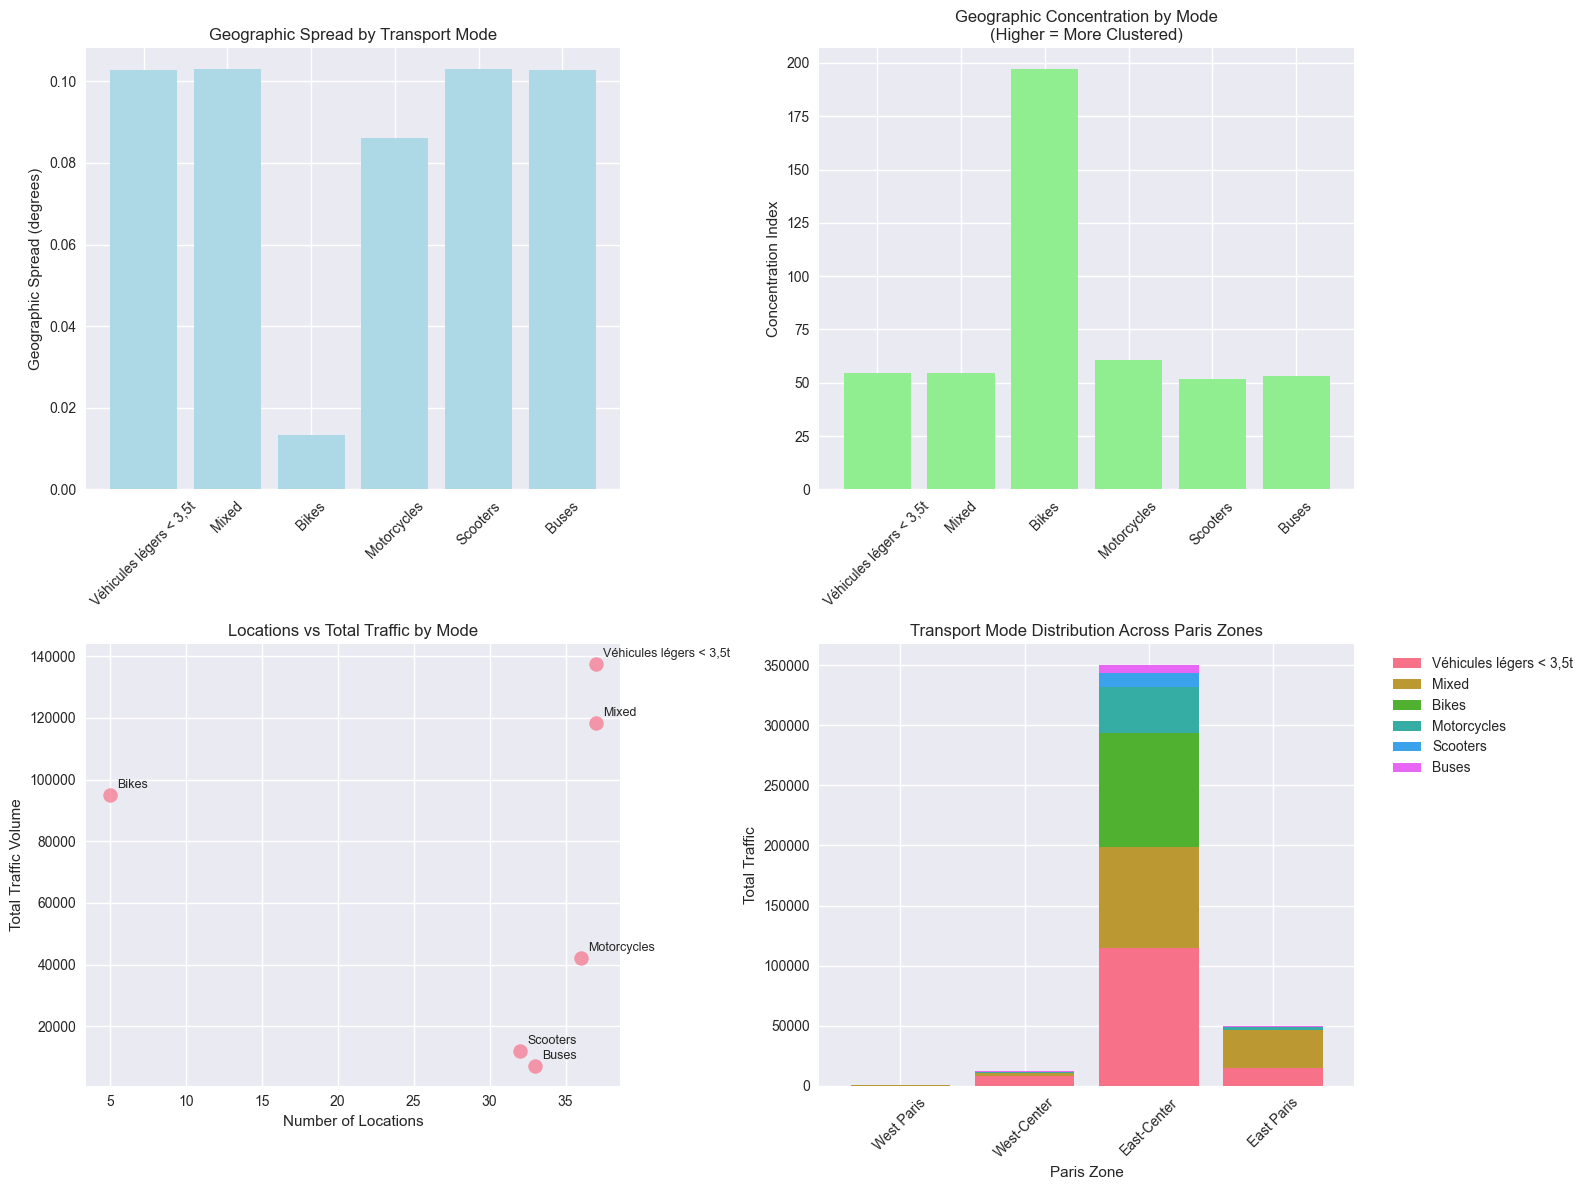


📊 DETAILED MODE ANALYSIS:

🚲 VÉHICULES LÉGERS < 3,5T:
   📍 Locations: 37
   🚦 Total Traffic: 137,347
   📏 Geographic Spread: 0.1028°
   🎯 Concentration: 54.83
   🏆 Top Location: CF0004_2 boulevard Montmartre (sens E-O)
   📈 Peak Traffic: 40,245

🚲 MIXED:
   📍 Locations: 37
   🚦 Total Traffic: 118,261
   📏 Geographic Spread: 0.1030°
   🎯 Concentration: 54.72
   🏆 Top Location: CF0181_101 rue d'Amsterdam
   📈 Peak Traffic: 19,777

🚲 BIKES:
   📍 Locations: 5
   🚦 Total Traffic: 94,916
   📏 Geographic Spread: 0.0133°
   🎯 Concentration: 197.16
   🏆 Top Location: CF0256_88 rue de Rivoli
   📈 Peak Traffic: 38,320

🚲 MOTORCYCLES:
   📍 Locations: 36
   🚦 Total Traffic: 42,266
   📏 Geographic Spread: 0.0860°
   🎯 Concentration: 60.60
   🏆 Top Location: CF0004_2 boulevard Montmartre (sens E-O)
   📈 Peak Traffic: 18,378

🚲 SCOOTERS:
   📍 Locations: 32
   🚦 Total Traffic: 12,103
   📏 Geographic Spread: 0.1030°
   🎯 Concentration: 51.63
   🏆 Top Location: CF0256_88 rue de Rivoli
   📈 Peak Traffic:

In [15]:
# Analyze geographic patterns for each transport mode
print("🗺️ TRANSPORT MODE GEOGRAPHIC PATTERNS")
print("=" * 50)

mode_insights = {}

for mode in top_modes:
    mode_data = df_geo[df_geo['mode_clean'] == mode]
    mode_locations = mode_data.groupby(['longitude', 'latitude', 'site_label'])['count'].sum().reset_index()
    
    if len(mode_locations) > 0:
        # Calculate geographic spread
        lon_spread = mode_locations['longitude'].max() - mode_locations['longitude'].min()
        lat_spread = mode_locations['latitude'].max() - mode_locations['latitude'].min()
        
        # Find geographic center
        center_lon = mode_locations['longitude'].mean()
        center_lat = mode_locations['latitude'].mean()
        
        # Calculate concentration (how clustered the locations are)
        distances_from_center = np.sqrt(
            (mode_locations['longitude'] - center_lon)**2 + 
            (mode_locations['latitude'] - center_lat)**2
        )
        concentration = 1 / (distances_from_center.std() + 0.001)  # Higher = more concentrated
        
        mode_insights[mode] = {
            'locations': len(mode_locations),
            'total_traffic': mode_locations['count'].sum(),
            'geographic_spread': (lon_spread + lat_spread) / 2,
            'concentration': concentration,
            'center': (center_lat, center_lon),
            'top_location': mode_locations.loc[mode_locations['count'].idxmax(), 'site_label'],
            'top_traffic': mode_locations['count'].max()
        }

# Create comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Geographic spread comparison
modes = list(mode_insights.keys())
spreads = [mode_insights[mode]['geographic_spread'] for mode in modes]
ax1.bar(modes, spreads, color='lightblue')
ax1.set_title('Geographic Spread by Transport Mode')
ax1.set_ylabel('Geographic Spread (degrees)')
ax1.tick_params(axis='x', rotation=45)

# 2. Concentration analysis
concentrations = [mode_insights[mode]['concentration'] for mode in modes]
ax2.bar(modes, concentrations, color='lightgreen')
ax2.set_title('Geographic Concentration by Mode\n(Higher = More Clustered)')
ax2.set_ylabel('Concentration Index')
ax2.tick_params(axis='x', rotation=45)

# 3. Traffic volume vs number of locations
locations_count = [mode_insights[mode]['locations'] for mode in modes]
total_traffic = [mode_insights[mode]['total_traffic'] for mode in modes]
scatter = ax3.scatter(locations_count, total_traffic, s=100, alpha=0.7)
ax3.set_title('Locations vs Total Traffic by Mode')
ax3.set_xlabel('Number of Locations')
ax3.set_ylabel('Total Traffic Volume')

# Add mode labels to points
for i, mode in enumerate(modes):
    ax3.annotate(mode, (locations_count[i], total_traffic[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# 4. Mode distribution across Paris zones
# Create zones based on longitude
df_geo['paris_zone'] = pd.cut(df_geo['longitude'], 
                             bins=4, 
                             labels=['West Paris', 'West-Center', 'East-Center', 'East Paris'])

zone_mode_traffic = df_geo.groupby(['paris_zone', 'mode_clean'])['count'].sum().unstack(fill_value=0)
zone_mode_traffic = zone_mode_traffic[top_modes]  # Only show top modes

zone_mode_traffic.plot(kind='bar', stacked=True, ax=ax4, width=0.8)
ax4.set_title('Transport Mode Distribution Across Paris Zones')
ax4.set_xlabel('Paris Zone')
ax4.set_ylabel('Total Traffic')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print detailed insights
print("\n📊 DETAILED MODE ANALYSIS:")
for mode, data in mode_insights.items():
    print(f"\n🚲 {mode.upper()}:")
    print(f"   📍 Locations: {data['locations']}")
    print(f"   🚦 Total Traffic: {data['total_traffic']:,}")
    print(f"   📏 Geographic Spread: {data['geographic_spread']:.4f}°")
    print(f"   🎯 Concentration: {data['concentration']:.2f}")
    print(f"   🏆 Top Location: {data['top_location']}")
    print(f"   📈 Peak Traffic: {data['top_traffic']:,}")

In [16]:
# Score locations for commercial potential
location_metrics = df.groupby('site_label').agg({
    'count': ['sum', 'mean', 'std'],
    'mode_clean': 'nunique',
    'hour': lambda x: len(set(x))
}).round(2)

location_metrics.columns = ['Total_Traffic', 'Avg_Traffic', 'Traffic_Std', 'Mode_Diversity', 'Active_Hours']

# Create composite score
scaler = StandardScaler()
location_metrics['Volume_Score'] = scaler.fit_transform(location_metrics[['Total_Traffic']])
location_metrics['Consistency_Score'] = scaler.fit_transform(1/(location_metrics[['Traffic_Std']] + 1))
location_metrics['Diversity_Score'] = scaler.fit_transform(location_metrics[['Mode_Diversity']])

location_metrics['Commercial_Score'] = (
    location_metrics['Volume_Score'] * 0.5 +
    location_metrics['Consistency_Score'] * 0.3 +
    location_metrics['Diversity_Score'] * 0.2
).round(3)

location_metrics = location_metrics.sort_values('Commercial_Score', ascending=False)

print("TOP 15 COMMERCIAL OPPORTUNITIES")
print(location_metrics[['Total_Traffic', 'Mode_Diversity', 'Commercial_Score']].head(15))

TOP 15 COMMERCIAL OPPORTUNITIES
                                                    Total_Traffic  \
site_label                                                          
                                                           128814   
CF0256_88 rue de Rivoli                                     69664   
CF0004_2 boulevard Montmartre (sens E-O)                    71913   
CF0892_65 rue de Rivoli (Bourdonnais)                       66293   
CF0548_48 rue du Château-Landon                               455   
CF0318_29 rue de Rivoli (Lobau)                             50046   
CF1661_80 avenue du Général Leclerc (sens N-S)               1366   
CF1873_20 boulevard Ney (piste tram Pte d'Auber...            361   
CF0181_101 rue d'Amsterdam                                  36921   
CF0004_29 boulevard Poissonnière (sens O-E)                 21823   
CF1062_90 boulevard Exelmans (sens SE-NO)                     436   
CF1172_231 rue La Fayette                                     660   
CF

In [19]:
# Simple clean exports for PowerBI
import os
os.makedirs('../data/processed/', exist_ok=True)

# 1. Main traffic dataset - cleaned and ready
traffic_clean = df.copy()
traffic_clean.to_csv('../data/processed/vehicle_traffic_clean.csv', index=False)

# 2. Traffic by location summary
location_summary = df.groupby(['site_id', 'site_label', 'longitude', 'latitude']).agg({
    'count': ['sum', 'mean', 'count'],
    'mode_clean': 'nunique'
}).round(2)
location_summary.columns = ['total_traffic', 'avg_traffic', 'measurements', 'transport_modes']
location_summary.reset_index().to_csv('../data/processed/location_summary.csv', index=False)

# 3. Traffic by transport mode
mode_summary = df.groupby('mode_clean').agg({
    'count': ['sum', 'mean', 'count'],
    'site_id': 'nunique'
}).round(2)
mode_summary.columns = ['total_traffic', 'avg_traffic', 'measurements', 'unique_sites']
mode_summary.reset_index().to_csv('../data/processed/mode_summary.csv', index=False)

print("✅ Clean files exported to ../data/processed/:")
print("  • vehicle_traffic_clean.csv")
print("  • location_summary.csv") 
print("  • mode_summary.csv")

✅ Clean files exported to ../data/processed/:
  • vehicle_traffic_clean.csv
  • location_summary.csv
  • mode_summary.csv


In [3]:
import pandas as pd
import numpy as np

# Load your vehicle traffic data
df = pd.read_csv('../data/processed/vehicle_traffic_clean.csv')

def get_arrondissement_from_coordinates(lat, lon):
    """
    Determine arrondissement from latitude/longitude coordinates
    Based on approximate Paris arrondissement boundaries
    """
    # Paris arrondissement boundaries (simplified)
    arrondissement_bounds = {
        1: (48.855, 48.870, 2.325, 2.350),   # lat_min, lat_max, lon_min, lon_max
        2: (48.865, 48.875, 2.335, 2.355),
        3: (48.855, 48.870, 2.350, 2.370),
        4: (48.850, 48.865, 2.345, 2.370),
        5: (48.835, 48.855, 2.340, 2.365),
        6: (48.840, 48.855, 2.320, 2.345),
        7: (48.850, 48.870, 2.300, 2.330),
        8: (48.870, 48.885, 2.300, 2.330),
        9: (48.870, 48.885, 2.330, 2.350),
        10: (48.870, 48.885, 2.350, 2.375),
        11: (48.850, 48.870, 2.370, 2.390),
        12: (48.830, 48.850, 2.370, 2.400),
        13: (48.815, 48.840, 2.350, 2.380),
        14: (48.820, 48.840, 2.310, 2.340),
        15: (48.835, 48.855, 2.285, 2.315),
        16: (48.845, 48.875, 2.265, 2.295),
        17: (48.875, 48.895, 2.290, 2.320),
        18: (48.885, 48.905, 2.330, 2.360),
        19: (48.875, 48.895, 2.370, 2.410),
        20: (48.855, 48.875, 2.385, 2.415)
    }
    
    for arr_num, (lat_min, lat_max, lon_min, lon_max) in arrondissement_bounds.items():
        if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
            return str(arr_num)
    
    return "Unknown"

def extract_arrondissement_from_site(site_label):
    """
    Extract arrondissement from site label using known Paris streets
    """
    if pd.isna(site_label):
        return None
        
    site_lower = site_label.lower()
    
    # Known street mappings to arrondissements
    street_mappings = {
        'rue de rivoli': '1',
        'louvre': '1',
        'châtelet': '1',
        'grands boulevards': '2',
        'opéra': '2',
        'république': '3',
        'marais': '3',
        'notre dame': '4',
        'latin': '5',
        'panthéon': '5',
        'saint germain': '6',
        'luxembourg': '6',
        'tour eiffel': '7',
        'invalides': '7',
        'champs élysées': '8',
        'arc de triomphe': '8',
        'pigalle': '9',
        'montmartre': '18',
        'sacré cœur': '18',
        'belleville': '19',
        'père lachaise': '20',
        'ménilmontant': '20'
    }
    
    for street_key, arr in street_mappings.items():
        if street_key in site_lower:
            return arr
    
    return None

# Add arrondissement column using coordinates (primary method)
print("Adding arrondissement based on coordinates...")
df['arrondissement_geo'] = df.apply(
    lambda row: get_arrondissement_from_coordinates(row['latitude'], row['longitude']), 
    axis=1
)

# Add arrondissement from site label (backup method)
print("Adding arrondissement from site labels...")
df['arrondissement_site'] = df['site_label'].apply(extract_arrondissement_from_site)

# Create final arrondissement column (prefer geo, fallback to site)
df['arrondissement'] = df['arrondissement_geo'].where(
    df['arrondissement_geo'] != 'Unknown', 
    df['arrondissement_site']
)

# Clean up intermediate columns
df = df.drop(['arrondissement_geo', 'arrondissement_site'], axis=1)

# Add 75000-format for consistency with other datasets
df['arrondissement_full'] = df['arrondissement'].apply(
    lambda x: f"75{str(x).zfill(3)}" if x and x != 'Unknown' else None
)

# Show results
print("\nArrondissement distribution:")
print(df['arrondissement'].value_counts().sort_index())

print(f"\nTotal records: {len(df)}")
print(f"Records with arrondissement: {len(df[df['arrondissement'].notna()])}")
print(f"Coverage: {len(df[df['arrondissement'].notna()]) / len(df) * 100:.1f}%")

# Save enhanced dataset
df.to_csv('../data/processed/vehicle_traffic_with_arrondissement.csv', index=False)
print("\nSaved enhanced dataset: vehicle_traffic_with_arrondissement.csv")

# Preview the data
print("\nSample records:")
print(df[['site_label', 'latitude', 'longitude', 'arrondissement', 'arrondissement_full']].head(10))

Adding arrondissement based on coordinates...
Adding arrondissement from site labels...

Arrondissement distribution:
arrondissement
1     2749
10     791
12      80
14     175
15      95
18      28
19     101
2     1433
3     1062
4       79
5       79
7      125
8      720
9       21
Name: count, dtype: int64

Total records: 10000
Records with arrondissement: 7538
Coverage: 75.4%

Saved enhanced dataset: vehicle_traffic_with_arrondissement.csv

Sample records:
                site_label   latitude  longitude arrondissement  \
0  CF0256_88 rue de Rivoli  48.858273   2.349109              1   
1  CF0256_88 rue de Rivoli  48.858273   2.349109              1   
2  CF0256_88 rue de Rivoli  48.858273   2.349109              1   
3  CF0256_88 rue de Rivoli  48.858273   2.349109              1   
4  CF0256_88 rue de Rivoli  48.858273   2.349109              1   
5  CF0256_88 rue de Rivoli  48.858273   2.349109              1   
6  CF0256_88 rue de Rivoli  48.858273   2.349109              1 